## Random Forest, Decision Tree, Gradient Boosting

First of all, let's load the dataset and look at its shape.

In [1]:
def prettify_ax(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_frameon=True
    ax.patch.set_facecolor('#eeeeef')
    ax.grid('on', color='w', linestyle='-', linewidth=1)
    ax.tick_params(direction='out')
    ax.set_axisbelow(True)

In [2]:
import pandas as pd
import numpy as np
import ast

In [3]:
data = pd.read_csv('Meta_data_First_All_Cleaned.csv')

data['Action'] = np.zeros(len(data))
data['Adventure'] = np.zeros(len(data))
data['Animation'] = np.zeros(len(data))
data['Comedy'] = np.zeros(len(data))
data['Crime'] = np.zeros(len(data))
data['Documentary'] = np.zeros(len(data))
data['Drama'] = np.zeros(len(data))
data['Family'] = np.zeros(len(data))
data['Fantasy'] = np.zeros(len(data))
data['History'] = np.zeros(len(data))
data['Horror'] = np.zeros(len(data))
data['Music'] = np.zeros(len(data))
data['Mystery'] = np.zeros(len(data))
data['Romance'] = np.zeros(len(data))
data['Science Fiction'] = np.zeros(len(data))
data['Thriller'] = np.zeros(len(data))
data['War'] = np.zeros(len(data))
data['Western'] = np.zeros(len(data))

cols = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 
        'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'Thriller', 'War', 'Western']

for col in cols:
    for i in range(len(data)):
        for j in range(len(ast.literal_eval(data.genres[i]))):
            if ast.literal_eval(data.genres[i])[j]['name'] == col:
                data[col][i] = 1
print data.columns

del data['genres']

print 'Size:', data.shape

/Users/nisreenshiban/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Index([u'Unnamed: 0', u'budget', u'director', u'genres', u'id', u'keywords',
       u'overview', u'popularity', u'poster_path', u'releaseyear', u'revenue',
       u'runtime', u'title', u'Action', u'Adventure', u'Animation', u'Comedy',
       u'Crime', u'Documentary', u'Drama', u'Family', u'Fantasy', u'History',
       u'Horror', u'Music', u'Mystery', u'Romance', u'Science Fiction',
       u'Thriller', u'War', u'Western'],
      dtype='object')
Size: (9988, 30)


We see, that there are a lot of columns that have NaN values, we need to somehow deal with that. 

Let's explore what columns have NaN values.

In [4]:
is_null_column = pd.isnull(data).any()
pd.DataFrame(is_null_column[is_null_column == True].index, columns=['Column name'])

,Column name
0,keywords
1,overview


As we see, two columns have NaN values. Let's see what percentage of values is NaN.

In [5]:
print round(100 * pd.isnull(data).values.sum() / float(data.shape[0] * data.shape[1]), 1)

0.8


As we see, a small amount of data is missing. We would need to deal with that later, when we use some model to do prediction. For now, let's keep them.

Let's now look at distributions of values in each column. 

As a start, let's draw a histogram for each column and then dig into features that are the most interesting/representative.

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999; // Prevent ipython from suppresing output.

<IPython.core.display.Javascript object>

We'll start by looking at numerical features.

In [8]:
data_n = data.copy()
data_n = data_n.loc[:,:'title']

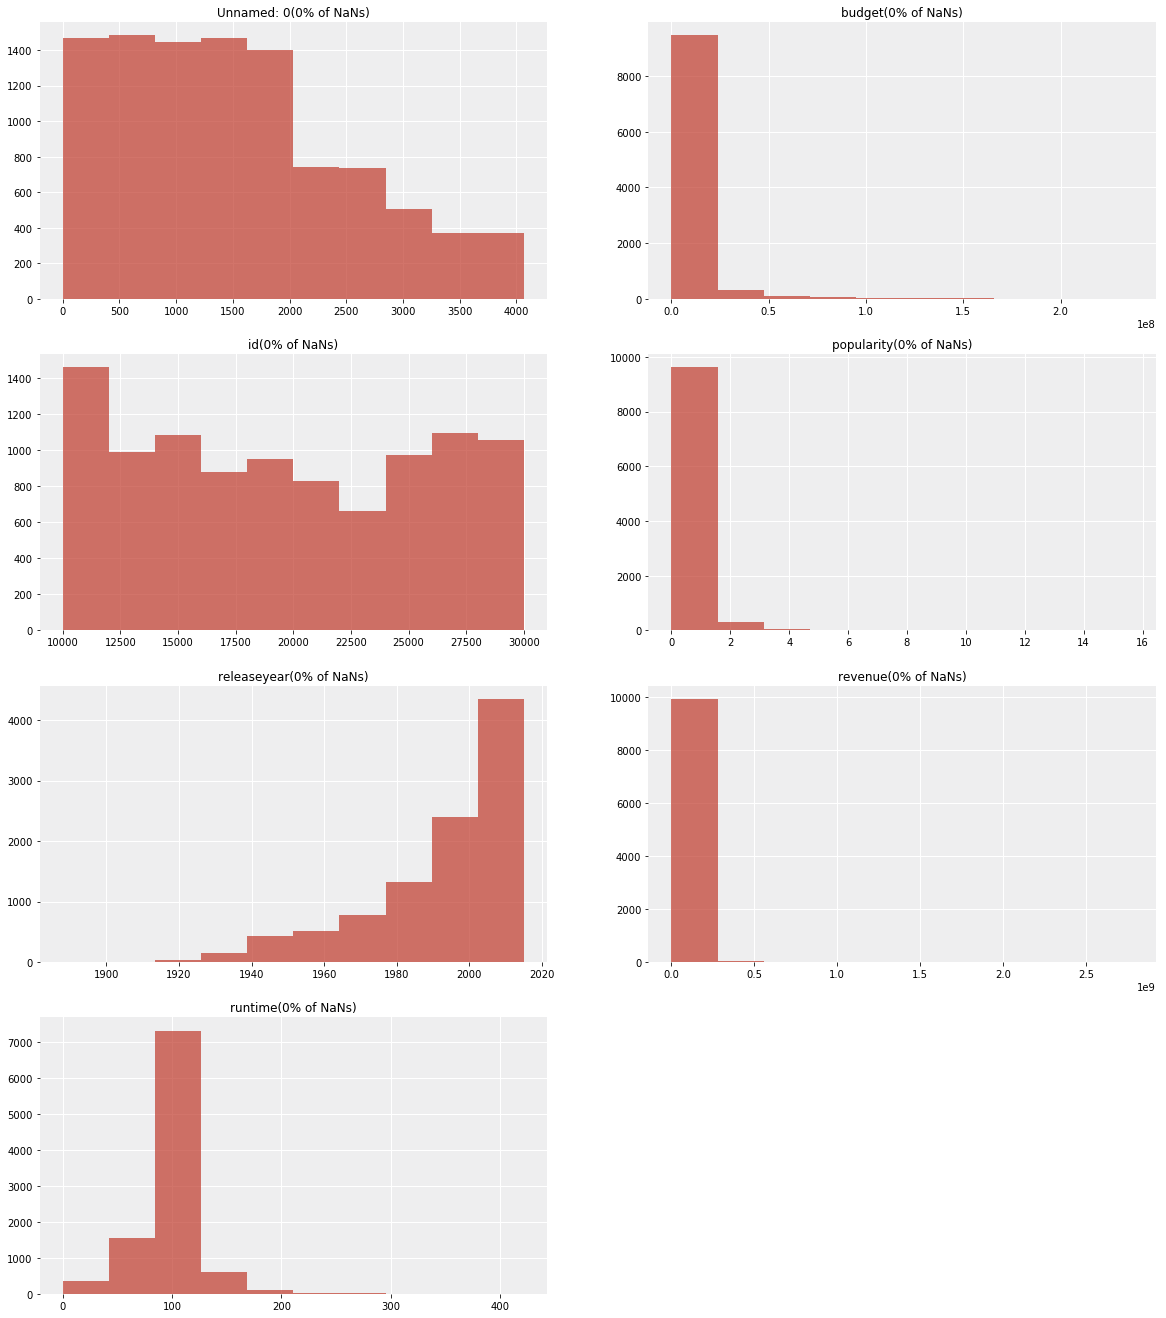

In [9]:
idx = 0
i = 1

plt.figure(figsize=(20, 60))
plt.subplots_adjust(hspace=0.2, wspace=0.2)

for column in data_n.columns:
    nonull_rows = data[column].notnull()
    nan_percentage = 100 * (1 - np.sum(nonull_rows) / float(data.shape[0]))
    if (data.dtypes[idx] == np.int64 or data.dtypes[idx] == np.float64):
        ax = plt.subplot(10, 2, i)
        
        plt.title(column + '(' + str(int(nan_percentage)) + '% of NaNs)');
        ax.hist(data[column][nonull_rows], color = '#c0392b', alpha = 0.7);
        prettify_ax(ax)
        i += 1
    idx += 1
plt.show()

On the other hand, some features mostly contain a single value - those would probably not be informative. But there are outliers that need to be kept in mind.

As we're trying to predict genres, let's look at them closer.

In [10]:
genres_cols = []

for i in cols:
    genres_cols.append(sum(data[i]))

/Users/nisreenshiban/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


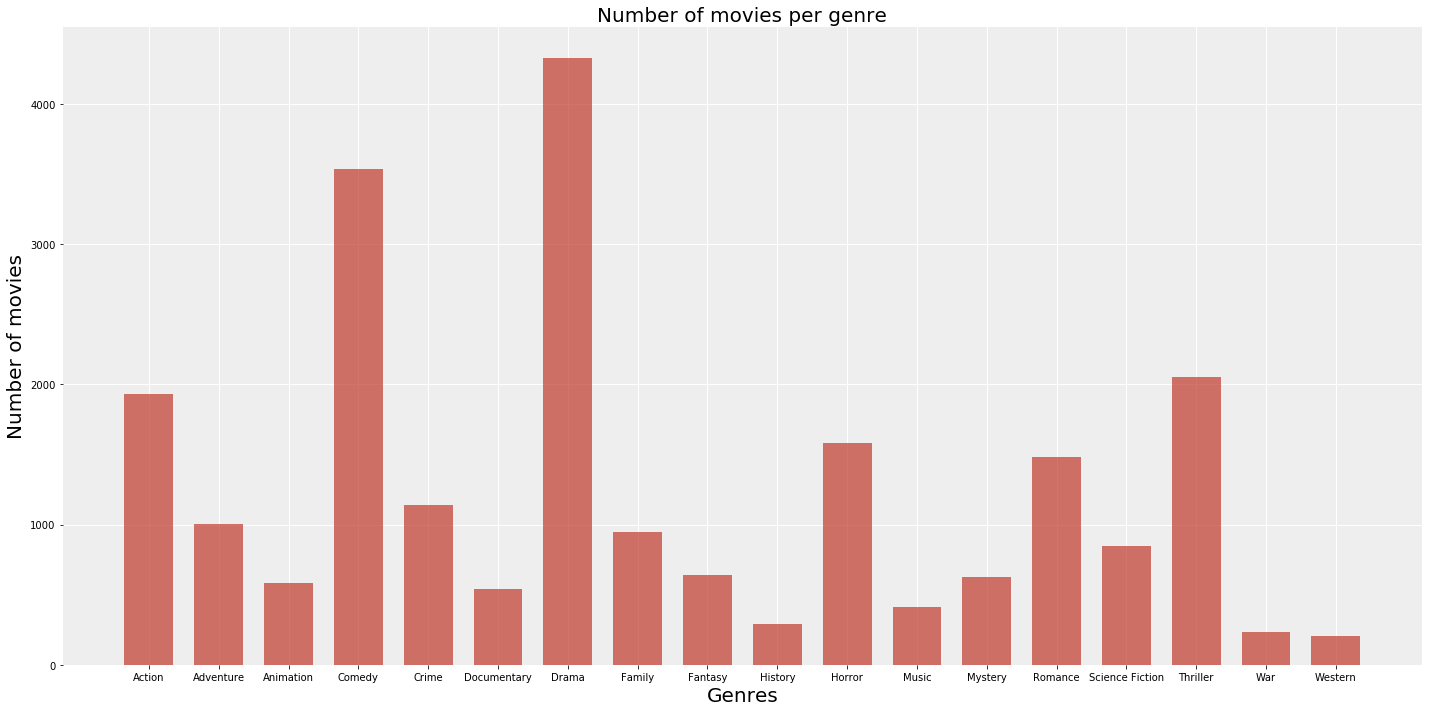

In [11]:
n_groups = len(cols)

fig, ax = plt.subplots(figsize=(20, 10))

index = np.arange(n_groups)
bar_width = 0.7

rects1 = plt.bar(index, genres_cols, bar_width, alpha = 0.7,
                 color='#c0392b')
plt.xlabel('Genres', fontsize=20)
plt.ylabel('Number of movies', fontsize=20)
plt.title('Number of movies per genre', fontsize = 20)
plt.xticks(index, cols)
prettify_ax(ax)
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
data.shape

(9988, 30)

To find out what features are relevant, we'll train Random Forest classifier. It provides off-shelf feature importance mechanism that we'll use in order to understand what feaures are most relevant to prediction task. 

For simple random forest model, we'll perform one-hot-encoding on categorical features and change all NaNs to column means (or mode for categorical).

In [27]:
del data['id']
del data['Unnamed: 0']

In [28]:
transformed_data = data.copy()
transformed_data = transformed_data.loc[:,:'title']

In [29]:
transformed_data.columns

Index([u'budget', u'director', u'keywords', u'overview', u'popularity',
       u'poster_path', u'releaseyear', u'revenue', u'runtime', u'title'],
      dtype='object')

In [30]:
idx = -1

drop_columns = []

for column in transformed_data.columns:
    idx += 1
    isnull = np.where(transformed_data[column].isnull())[0]
    if len(isnull) == 0:
        if not (transformed_data.dtypes[idx] == np.float64 or \
            transformed_data.dtypes[idx] == np.int64 or \
            transformed_data.dtypes[idx] == object):
            drop_columns.append(column)
        continue
    if (transformed_data.dtypes[idx] == np.float64 or transformed_data.dtypes[idx] == np.int64):
        transformed_data.iloc[isnull, idx] = np.nanmean(transformed_data[column])
    elif transformed_data.dtypes[idx] == object:
        transformed_data.iloc[isnull, idx] = 'NaN'
    else:
        drop_columns.append(column)
transformed_data.drop(drop_columns, axis=1, inplace=True)

We drop all categorical columns that have > threshold_count unique values.

In [31]:
count_threshold = 100
columns = transformed_data.columns[transformed_data.dtypes == object]
ohe_columns = filter(lambda x: len(np.unique(transformed_data[x])) < count_threshold, columns)
remove_columns = filter(lambda x: len(np.unique(transformed_data[x])) >= count_threshold, columns)


transformed_data.drop(remove_columns, axis=1, inplace=True)
transformed_data = pd.get_dummies(transformed_data, columns=ohe_columns)

Now we can train random forest on each genre to get feature importances.

Since the dataset is large, we'll take only 10% of it for speed purposes.

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

The validation accuracy of RF model is:  0.789046856227


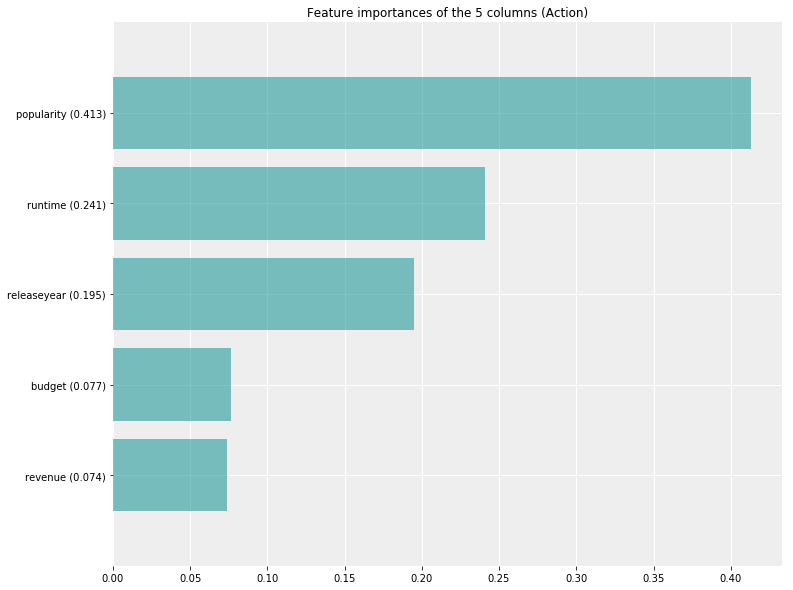

The validation accuracy of RF model is:  0.894873848618


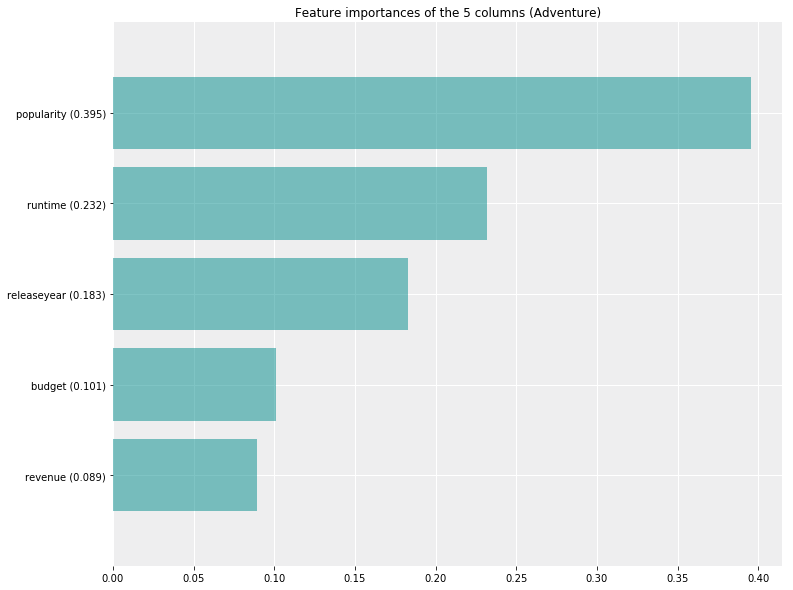

The validation accuracy of RF model is:  0.956848217861


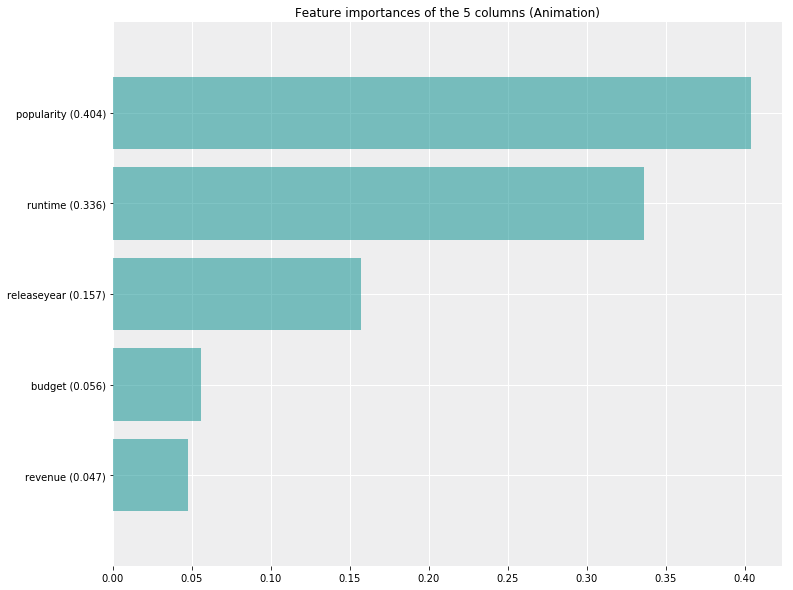

The validation accuracy of RF model is:  0.613636363636


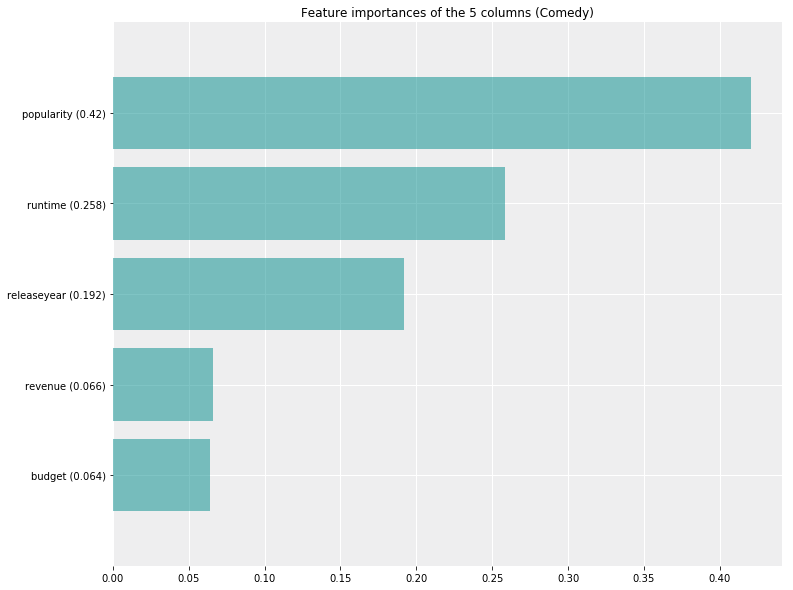

The validation accuracy of RF model is:  0.879054865839


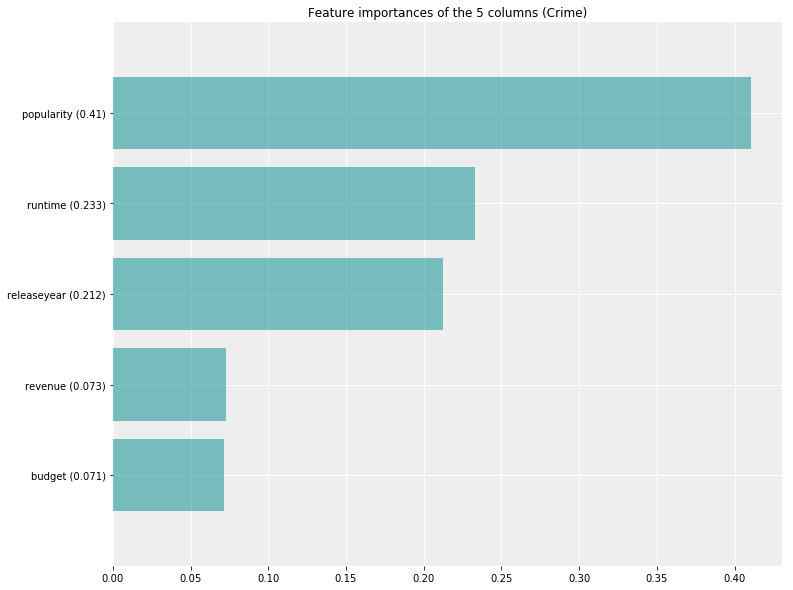

The validation accuracy of RF model is:  0.94433319984


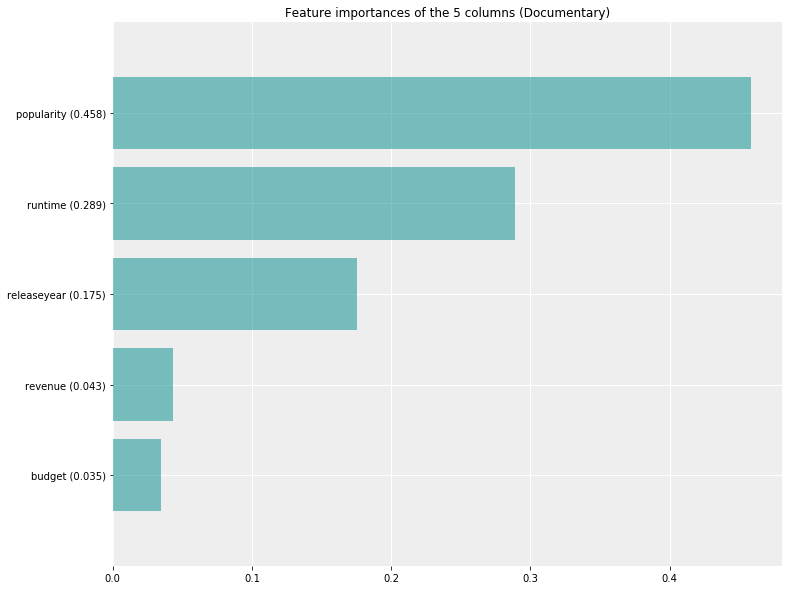

The validation accuracy of RF model is:  0.643271926312


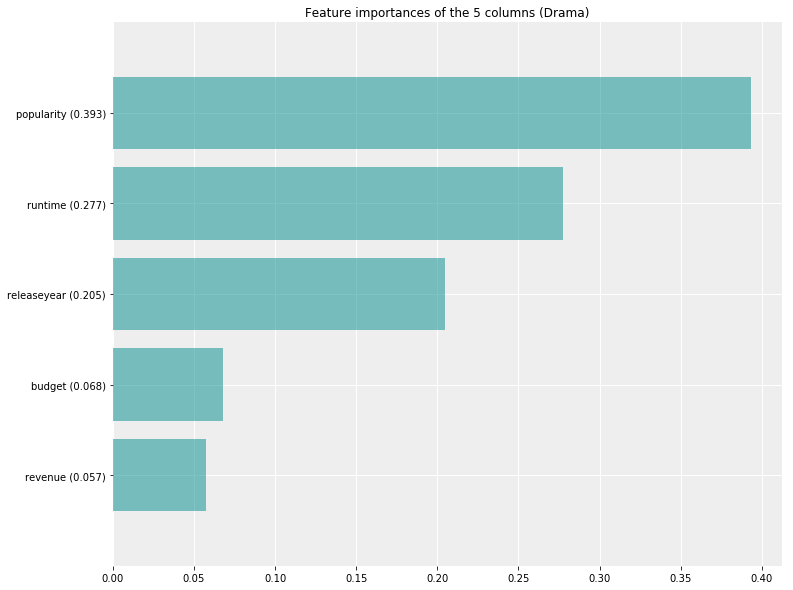

The validation accuracy of RF model is:  0.911593912695


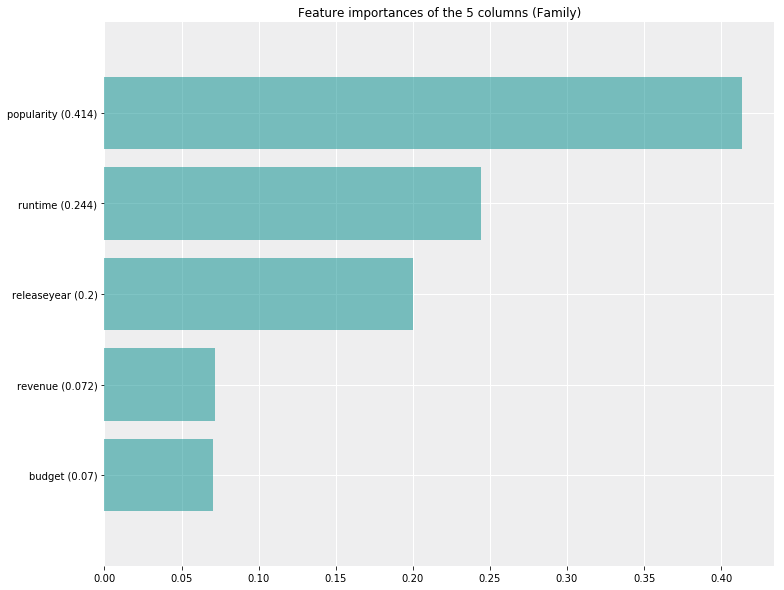

The validation accuracy of RF model is:  0.932719263116


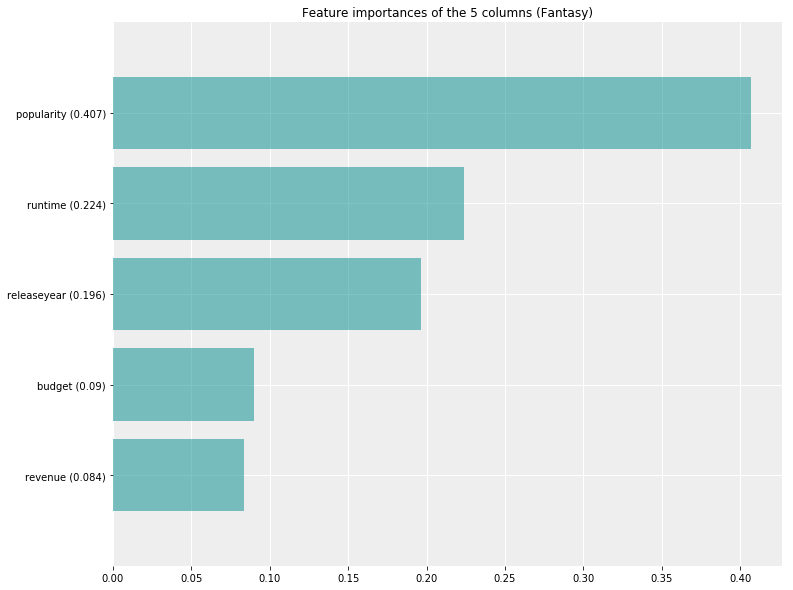

The validation accuracy of RF model is:  0.970164197036


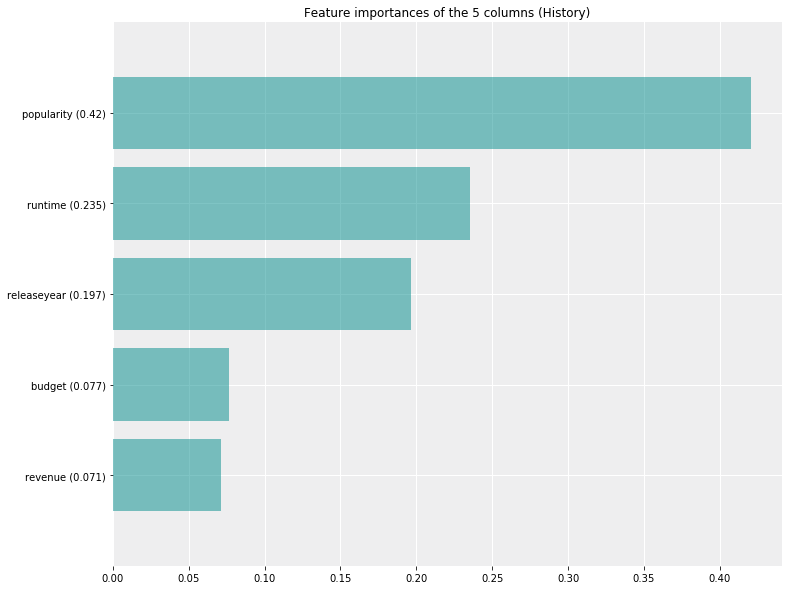

The validation accuracy of RF model is:  0.82749299159


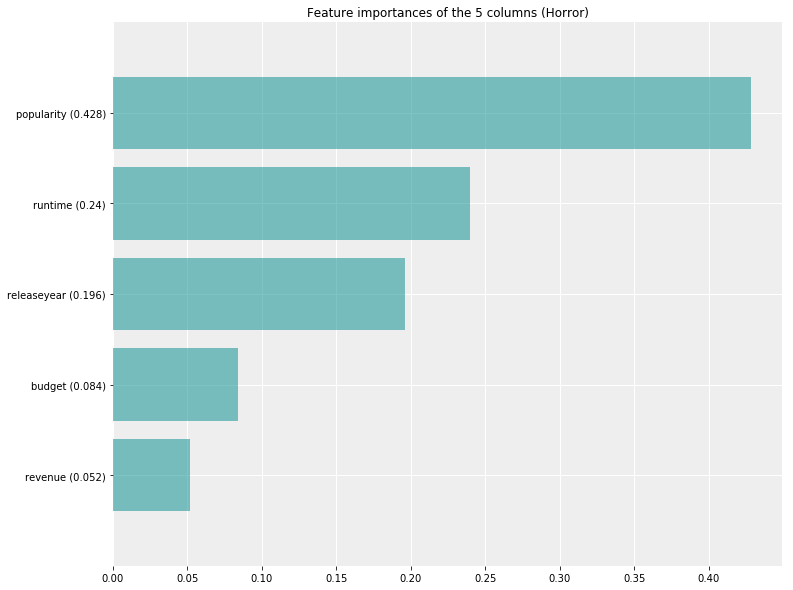

The validation accuracy of RF model is:  0.956948338006


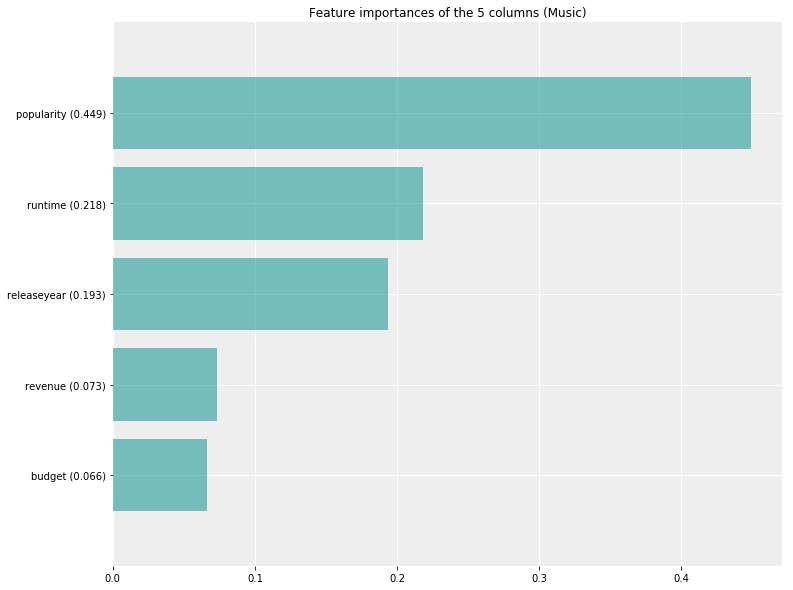

The validation accuracy of RF model is:  0.933520224269


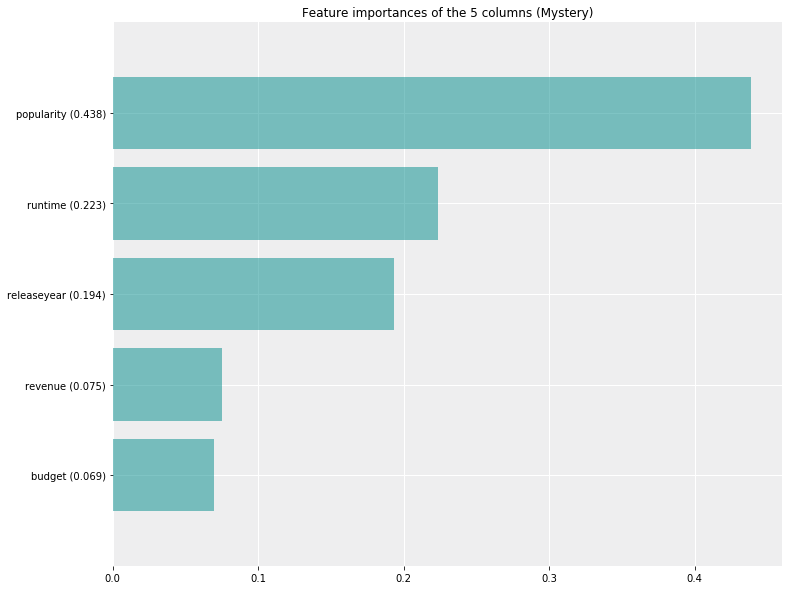

The validation accuracy of RF model is:  0.837905486584


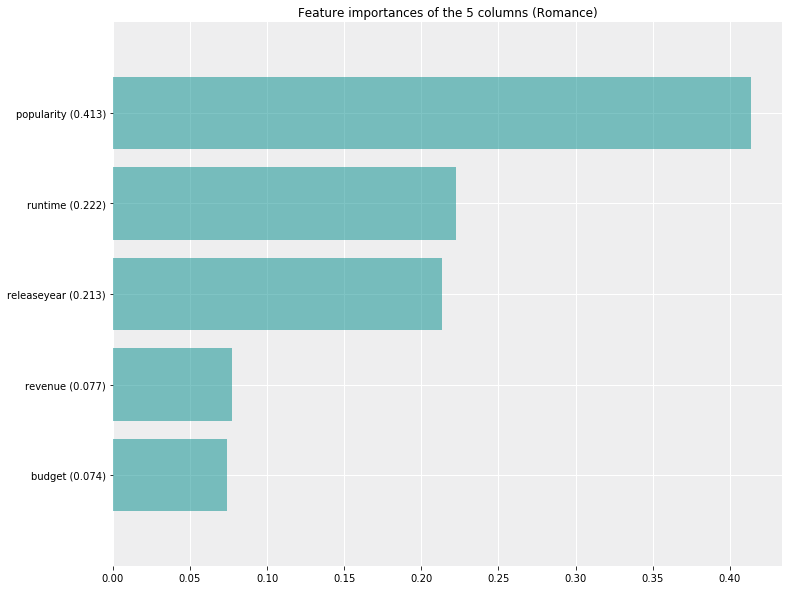

The validation accuracy of RF model is:  0.908990788947


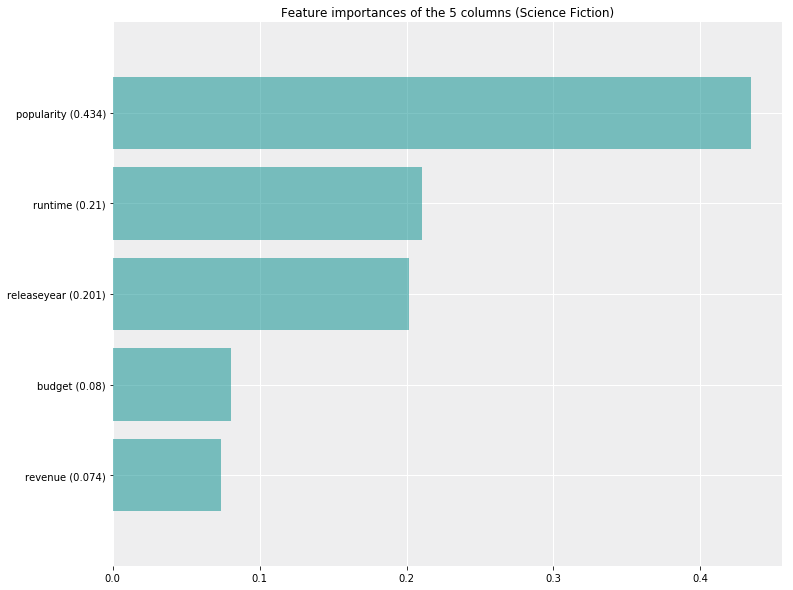

The validation accuracy of RF model is:  0.768922707249


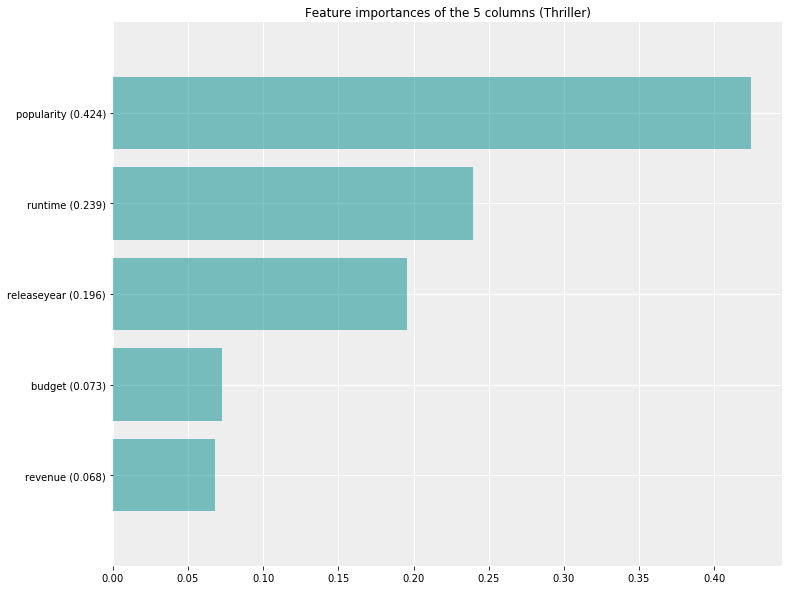

The validation accuracy of RF model is:  0.976071285543


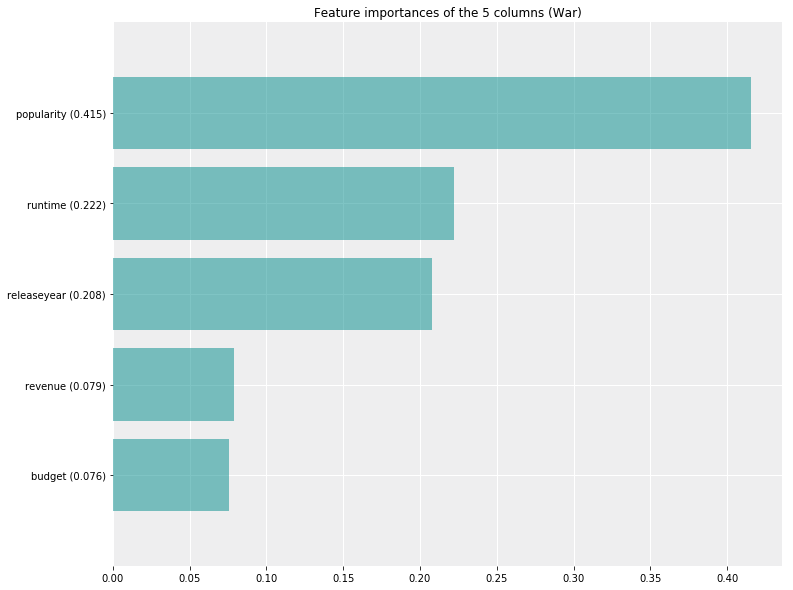

The validation accuracy of RF model is:  0.979275130156


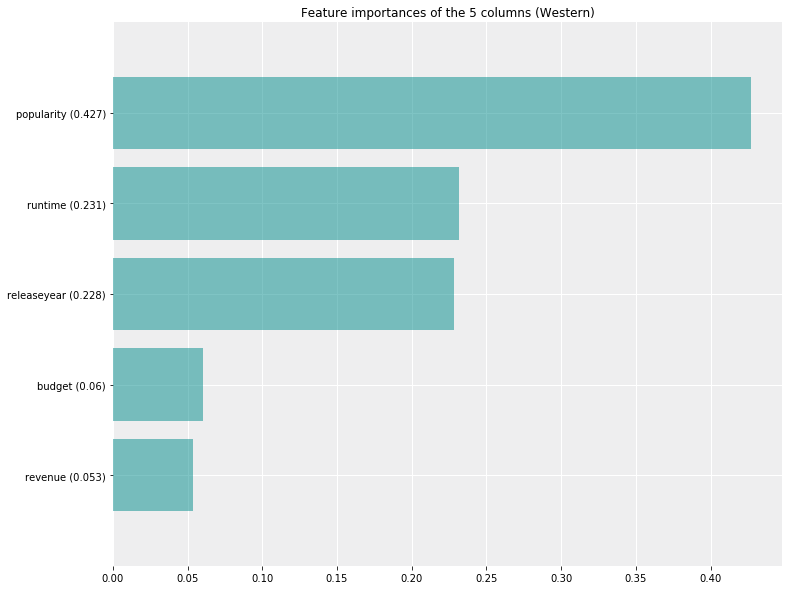

In [34]:
for col in cols:
    transformed_y = data[col]

    # Now we can train random forest
    grid_search = GridSearchCV(RandomForestClassifier(n_estimators=100, random_state=123), \
                            {}, cv=5)
    
    grid_search.fit(transformed_data, transformed_y)

    print 'The validation accuracy of RF model is: ', grid_search.best_score_


    #As we can see, model already works great. 
    #At this points, it's not really clear whether we overfit the data (since we used KFold as a crossvalidation).
    count = 5
    clf = grid_search.best_estimator_
    importances = clf.feature_importances_
    std = np.std([clf.feature_importances_ for tree in clf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1][:count][::-1]

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111)

    plt.title("Feature importances of the " + str(count) + " columns (" + col + ")")
    ax.barh(range(count), importances[indices],
           color="darkcyan", alpha= 0.5, yerr=std[indices], align="center")

    column_labels = [transformed_data.columns[idx] + ' (' + str(round(importances[idx], 3)) + ')' for idx in indices]

    plt.yticks(range(count), column_labels)
    plt.ylim([-1, count])
    prettify_ax(ax)
    plt.show()


From the plot above, we see, that feature importances drop to zero quite rapidly. Only the first 5 features for each genre (in this simple model, we really need to be skeptical of it) contain useful information.

## Recap

After doing exploratory analysis, we did couple of observations and found some relationships, that are summarized here.

* There are not a lot of missing values. 

* There are two categorical features. Since most ML algorithms can't deal with them, we performed One-Hot-Encoding to get numerical representations of them. It's worth noting, that this approach did not work on these categorical features, that have small number of unique values. Here, these columns had many unique values. We won't use them in our model.

* Some columns are highly correlated. Usually that's not a problem since in all models we would have some regularization term, that would prevent bad influence of these correlations.

* We fit Random Forest model saw, that there are not many features that this model used to predict an outcome. Also, we explored top relevant features, and detected, that IDs had large impact on prediction. That's a type of overfitting and to avoid it we would remove that columnns.

We run random forest model one more time to get feature importances.

Now, instead of KFold we use hold-out dateset to see whether model overfits.

## Random Forest

In [35]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

for col in cols:
    
    X_train, X_test, y_train, y_test = train_test_split(transformed_data, data[col], test_size=0.3, random_state=123)



    rf_model = RandomForestClassifier(n_estimators=10, random_state=123)
    rf_model.fit(X_train, y_train)

    #Now we'll compute accuracy of prediction of test set


    y_test_predicted = rf_model.predict(X_test)

    print 'Validation accuracy for', col, accuracy_score(y_test, y_test_predicted)

    # We see, that accuracy increased even more.

Validation accuracy for Action 0.780780780781
Validation accuracy for Adventure 0.885218551885
Validation accuracy for Animation 0.952619285953
Validation accuracy for Comedy 0.609275942609
Validation accuracy for Crime 0.877877877878
Validation accuracy for Documentary 0.941274607941
Validation accuracy for Drama 0.62028695362
Validation accuracy for Family 0.914914914915
Validation accuracy for Fantasy 0.932599265933
Validation accuracy for History 0.969302635969
Validation accuracy for Horror 0.824824824825
Validation accuracy for Music 0.955955955956
Validation accuracy for Mystery 0.932932932933
Validation accuracy for Romance 0.820820820821
Validation accuracy for Science Fiction 0.90990990991
Validation accuracy for Thriller 0.764097430764
Validation accuracy for War 0.974974974975
Validation accuracy for Western 0.976976976977


In [36]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score

def test_score(estimator):
    preds = estimator.predict(X_test)
    return accuracy_score(y_test, preds)

## Random Forest, Decision Tree, and Gradient Boosting

Random forest has more parameters to set: number of estimators, split criteria, maximum features to account in each tree and max depth of each tree.

In [37]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

gen_n = np.array([1,0])

def evaluate_model(classifier):
    preds = classifier.predict(X_test)
    print 'F1 score:', f1_score(y_test, preds, average='weighted')
    conf_matrix = pd.DataFrame(confusion_matrix(y_test, preds))
    conf_matrix.columns = gen_n
    
    conf_matrix.index = gen_n
    
    conf_matrix.columns.name = 'Predicted Label'
    conf_matrix.index.name = 'True Label'

    return conf_matrix
    

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import joblib


for col in cols:
    
    X_train, X_test, y_train, y_test = train_test_split(transformed_data, data[col], test_size=0.3, random_state=123)
    train_size = X_train.shape[0]
    
    part_percentage = 0.02
    X_train_part = X_train.ix[:int(train_size * part_percentage), :]
    y_train_part = y_train.ix[:int(train_size * part_percentage)]

    params = {
        'n_estimators' : [10],
        'criterion' : ['gini', 'entropy'],
        'max_features' : ['sqrt', 'log2'],
        'max_depth' : np.arange(5, 25, 2)
    }

    grid = GridSearchCV(RandomForestClassifier(random_state=123), params, n_jobs=-1, cv=5)
    grid.fit(X_train_part, y_train_part)

    print '---------------------------------------------------------------------------------------------------'
    print 'Random Forest Classifier'
    print '---------------------------------------------------------------------------------------------------'

    print col,":" 
    print 'Score:', grid.best_score_
    print 'Params:', grid.best_params_
    print 'Hold-out score:', test_score(grid.best_estimator_)
    rf = grid.best_estimator_
    
    scores = []
    number_of_estimators = range(10, 100, 10)

    #Once we found best parameters, let's see whether accuracy improves when we increase number of estimators.
    for n_est in number_of_estimators:
        model = RandomForestClassifier(n_estimators=n_est, criterion='gini', max_features='sqrt', \
                                       max_depth=21, random_state=123)
        model.fit(X_train_part, y_train_part)
        scores.append(test_score(model))
    
    print number_of_estimators
    print scores
    
    confusion = evaluate_model(rf)
    
    print confusion
  
    print '---------------------------------------------------------------------------------------------------'
    print 'Decision Tree Classifier'
    print '---------------------------------------------------------------------------------------------------'

    #Decision tree seems rational here, since when predicion loan outcome 
    #we usually need to understand the underlying process of deciding. That's where decision trees are good at
    params = {
        'criterion' : ['gini', 'entropy'],
        'max_features' : ['sqrt', 'log2', None],
        'max_depth' : np.arange(10, 20)
    }

    grid = GridSearchCV(DecisionTreeClassifier(), params, n_jobs=-1, cv=5)
    grid.fit(X_train_part, y_train_part)
    print col,":" 
    print 'Score:', grid.best_score_
    print 'Params:', grid.best_params_
    print 'Hold-out score:', test_score(grid.best_estimator_)
    dtree = grid.best_estimator_
    
    confusion = evaluate_model(dtree)
    
    print confusion
    
    print '---------------------------------------------------------------------------------------------------'
    print 'Gradient Boosting Classifier'
    print '---------------------------------------------------------------------------------------------------'

    # Gradient boosting represents more general approach. It's usually more powerful than AdaBoost
    params = {
        'n_estimators' : range(10, 60, 10)
    }

    grid = GridSearchCV(GradientBoostingClassifier(random_state=123), params, cv=5)
    grid.fit(X_train_part, y_train_part)
    print col,":" 
    print 'Score:', grid.best_score_
    print 'Params:', grid.best_params_
    print 'Hold-out score:', test_score(grid.best_estimator_)
    
    gradboost = grid.best_estimator_
    
    confusion = evaluate_model(dtree)
    
    print confusion
    
    _ = joblib.dump(rf, 'rf_part.joblib', compress=3)
    _ = joblib.dump(dtree, 'dtree_part.joblib', compress=3)
    _ = joblib.dump(gradboost, 'gradboost_part.joblib', compress=3)

---------------------------------------------------------------------------------------------------
Random Forest Classifier
---------------------------------------------------------------------------------------------------
Action :
Score: 0.805625
Params: {'max_features': 'sqrt', 'n_estimators': 10, 'criterion': 'gini', 'max_depth': 5}
Hold-out score: 0.807474140807
[10, 20, 30, 40, 50, 60, 70, 80, 90]
[0.7811144477811145, 0.78712045378712048, 0.7911244577911245, 0.7927927927927928, 0.79379379379379378, 0.79412746079412744, 0.79312645979312646, 0.79379379379379378, 0.79612946279612951]
F1 score: 0.724585560571
Predicted Label     1  0
True Label              
1                2415  5
0                 572  5
---------------------------------------------------------------------------------------------------
Decision Tree Classifier
---------------------------------------------------------------------------------------------------
Action :
Score: 0.786041666667
Params: {'max_features':

/Users/nisreenshiban/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Crime :
Score: 0.87375
Params: {'max_features': 'sqrt', 'criterion': 'entropy', 'max_depth': 10}
Hold-out score: 0.878878878879
F1 score: 0.836890289687
Predicted Label     1   0
True Label               
1                2624  39
0                 324  10
---------------------------------------------------------------------------------------------------
Gradient Boosting Classifier
---------------------------------------------------------------------------------------------------
Crime :
Score: 0.886041666667
Params: {'n_estimators': 40}
Hold-out score: 0.887887887888
F1 score: 0.836890289687
Predicted Label     1   0
True Label               
1                2624  39
0                 324  10
---------------------------------------------------------------------------------------------------
Random Forest Classifier
---------------------------------------------------------------------------------------------------
Documentary :
Score: 0.943958333333
Params: {'max_features': 'sqrt', '

The above plots look like a straight line, so we can choose number of estimators equal to 10.

We'll save all the models so that we don't need to refit them.

This part loads models from file. We uncomment if we already trained models.

In [ ]:
# import joblib
# rf = joblib.load('rf_part.joblib')
# dtree = joblib.load('dtree_part.joblib')
# gradboost = joblib.load('gradboost_part.joblib')

## Model Comparison and Evaluation

Now, we have all this models trained. There are number of parameters that influence model:

* Speed (training and prediction time)
* Memory consumption
* Metrics score
* Interpretability 


1. **Speed**

    Since this report was created, all proposed models can be built in a reasonable time on a single machine. As for testing time, all provided models are much quicker to test than train, so it's also affordable. 
    
2. **Memory**

    Number of parameters of each model is very small compared to size of dataset, so after training it consumes very little memory.
    
3. **Metrics score**

    That is the main characteristic of the model. All others are just binary criterias - we won't take a model if it doesn't fit any of them. Among all models that satisfy all other criterias, we pick the model with highest metrics score.
    
    For each real problem we create own metrics to optimize. We propose two choices of metrics:
    
    * Accuracy. That means we conider all examples are weighted equally. That is usually not true, and it's not true in our problem, so that is not the best metric to choose.
    
    * F1-score. This metric account for class imbalance. As seen before, some classes have small number of examples. That gives the efffect that each class is weighted inverse proportional to class size. This metric is also not designed to this task. Though it would give more reasonable results, since we'll penalize for not paying attention to some class,

4. **Interpretability**
    
    In genre prediction task, it would be great if human can evaluate the model and see how it makes its decisions, so that he could find maybe unreasonable decicsions/logic in algorithm's thinking. Not all the models provide a nice interpretation.
    
5. **Variance**

    How much different can results be when we train an algorithm mulitple times. That gives us the confidence about the prediction. We prefer variance to be small, but there's a bias-variance tradeoff.

As final metrics we'll take F1 score. We'll also plot confusion matrix to understand where algorithm makes mistakes.

Let's now evaluate each algorithm and choose the best one to our task.

### Random Forest

- Memory: memory consumption is pretty small.
- Interpretability: since RF is an ensemble method, it combines a lot of decision trees together and that's why it's not well interpreted.
- Variance: Since we average a lot of predictions, variance for this method is low.
- Metrics score: as we see, random forest produces very high F1-score. 

### Decision Tree

- Memory: memory consumption is pretty small.
- Interpretability: decision tree is great at understanding the underlying progress. We can see what decisions were made at each step of the algorithm.
- Variance: The exact tree shape highly depends on the training data. Even small changes can result into big changes in final model. This model has high variance.
- Metrics score: as we see, decision trees give us pretty high score. That means we can predict each person's loan status by "asking" series of questions about values of features.

### Gradient Boosting

GB is another to combining classifiers. It also lacks interpretability. 

But as we see, it has high F1 score, comparable to random forest model with makes it also possible for a best model.

## Results

The final choice of the model is not obvious. As stated above, it relies on the specific goal we want to accomplish.

For sure we need high accuracy and F1-score, and we used the following models:

* Random Forest
* Decision Tree
* Gradient Boosting

Scores of these models are comparable one to another. But decision tree has the property that it's interpretable, that can be critical in this problem. Also, the training time for this model is lowest. 